In [1]:
#loading data
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
mat = loadmat('Data/All_data_bigR.mat') 
mdata = mat['Dataset']  # variable in mat file
mdtype = mdata.dtype


df = pd.DataFrame(mdata,
                  columns = ['moments', 'minmax_scaled', 'minpeaks', 'maxpeaks',
                             'sum_peaks', 'r_minmax', 'r1','r2','r3',
                             'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
                             'r10', 'r11', 'r12','r13', 'r14', 'r15',
                             'r16', 'r17', 'r18', 'r19', 'r20', 'r21',
                             'r22', 'r23', 'r24', 'r25', 'r26', 'r27','r28','r29',
                             'r30','r31','r32','r33','r34','r35','r36','r37','r38',
                             'r39','r40','Z_labels']
                 )
df.loc[df['minpeaks'] >= 2, 'minpeaks'] = 2
df.loc[df['maxpeaks'] >= 2, 'maxpeaks'] = 2

In [2]:
#splitting data into train/test and processing to remove outliers in train
from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["Z_labels"]):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]
dropped_labels = ["Z_labels", "sum_peaks"] #drop sum_peaks as it is noise/linear with min peaks and max peaks
#already extract the test data - but first treat the training to remove outliers
X_test = strat_test_set.drop(dropped_labels, axis=1)
Y_test = strat_test_set["Z_labels"].copy()

train_X = strat_train_set.drop(dropped_labels, axis=1)#df_train_new.drop(dropped_labels, axis=1)
Y_train = strat_train_set["Z_labels"].copy()#df_train_new["Z_labels"].copy()


In [3]:
#processing data
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from factor_analyzer import FactorAnalyzer
from sklearn.compose import ColumnTransformer

num_attribs = ['moments', 'minmax_scaled', 'r_minmax', 'r1','r2','r3',
                             'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
                             'r10', 'r11', 'r12','r13', 'r14', 'r15',
                             'r16', 'r17', 'r18', 'r19', 'r20', 'r21',
                             'r22', 'r23', 'r24', 'r25', 'r26', 'r27','r28','r29',
                             'r30','r31','r32','r33','r34','r35','r36','r37','r38',
                             'r39','r40']   

cat_attribs = ['minpeaks','maxpeaks']

factored_num_pipeline = Pipeline([
    ("Factor_analysis", FactorAnalyzer(n_factors=9, rotation="varimax")),
])

full_pipeline = ColumnTransformer([
    ("num", factored_num_pipeline, num_attribs), #call the num_pipeline defined above on numerical attribs
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs), #call OneHotEncoder on categorical attribs
])

train_X_final = full_pipeline.fit_transform(train_X)

In [4]:
#training model
from sklearn.ensemble import VotingRegressor
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

xgb_model = xgb.XGBRegressor(booster= 'gbtree', tree_method='hist',  subsample=0.5, learning_rate=0.025, reg_alpha = 0.5,
                           n_estimators=400, max_depth=14, n_jobs=-1, verbosity=0, random_state=42, 
                           objective='reg:squarederror')

ERT_model = ExtraTreesRegressor(n_estimators=200, max_features=None, 
                                max_depth = 50 ,verbose=False, random_state=42, n_jobs=-1)

RF_model = RandomForestRegressor(n_estimators=300, max_features=6, n_jobs=-1, 
                                 max_depth = 50 ,verbose=True, random_state=42)

estimators= [('ExtremeTrees', ERT_model), 
#            ('RandomForest', RF_model),
            ('XGBOOST', xgb_model)]

complete_model = VotingRegressor(estimators= estimators, verbose=True)
complete_model.fit(train_X_final,Y_train)

[Voting] ............. (1 of 2) Processing ExtremeTrees, total=   5.2s
[Voting] .................. (2 of 2) Processing XGBOOST, total=  15.6s


VotingRegressor(estimators=[('ExtremeTrees',
                             ExtraTreesRegressor(max_depth=50,
                                                 max_features=None,
                                                 n_estimators=200, n_jobs=-1,
                                                 random_state=42,
                                                 verbose=False)),
                            ('XGBOOST',
                             XGBRegressor(base_score=None, booster='gbtree',
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          int..._constraints=None,
                                          learning_rate=0.025,
              

In [5]:
#transforming test data with pipeline on train
X_test_final = full_pipeline.transform(X_test)

Residuals without removing outliers: 0.5208519160109587 
 Residuals with outliers removed: 0.5098894486385539
num outliers: 9, % outliers: 0.0011470813153199083


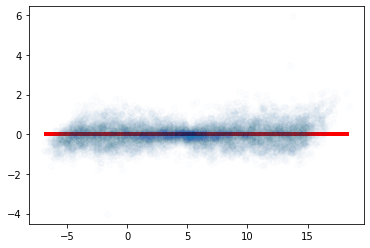

In [6]:
from sklearn.metrics import mean_squared_error

def Tukey_IQR(array, low=25, high=75, outlier_var = 1.5):
    import numpy as np
    LQR = np.percentile(array, low)
    UQR = np.percentile(array, high)
    IQR = UQR-LQR
    return LQR - outlier_var*IQR, UQR + outlier_var*IQR

def Tukey_outlier_detection(array, low=25, high=75, outlier_var=1.5):
    L, H = Tukey_IQR(array, low, high, outlier_var)
    return np.where((array < L) | (array > H))[0]

final_predictions = complete_model.predict(X_test_final)
# final_predictions = model.predict(X_test_final)
residuals = Y_test.to_numpy()-final_predictions

outliers = Tukey_outlier_detection(residuals, outlier_var=3) #due to poor labelling
Y_test_no_outliers = np.delete(Y_test.to_numpy(),(outliers))
residuals_no_outliers = np.delete(residuals,(outliers))
final_preds_no_outliers = np.delete(final_predictions,(outliers))

plt.plot(Y_test,residuals,'o', alpha=0.01)
# plt.plot(Y_test_no_outliers,residuals_no_outliers,'o', alpha=0.1)
plt.hlines(0,min(Y_test),max(Y_test),color='r',linewidth=4)
print(f"Residuals without removing outliers: {np.sqrt(mean_squared_error(Y_test, final_predictions))} \n Residuals with outliers removed: {np.sqrt(mean_squared_error(Y_test_no_outliers, final_preds_no_outliers))}")
print(f"num outliers: {len(outliers)}, % outliers: {len(outliers)/len(strat_test_set)}")

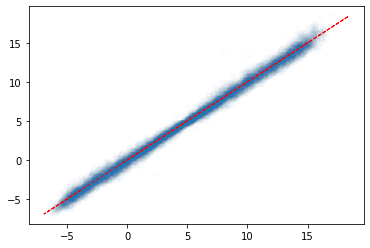

In [7]:
plt.plot(final_predictions,Y_test,'o', alpha=0.01)
plt.plot(Y_test,Y_test,'r--', linewidth=1)

(array([ 6., 10., 13., 24., 22.,  6.,  9.,  3.,  3.,  5., 12.,  9., 19.,
        22., 35., 14., 22., 22., 20.,  7.]),
 array([-6.2 , -4.97, -3.74, -2.51, -1.28, -0.05,  1.18,  2.41,  3.64,
         4.87,  6.1 ,  7.33,  8.56,  9.79, 11.02, 12.25, 13.48, 14.71,
        15.94, 17.17, 18.4 ]),
 <BarContainer object of 20 artists>)

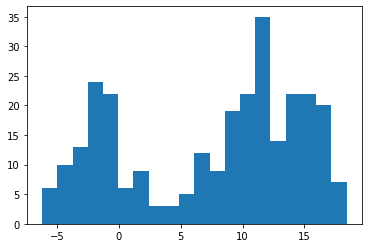

In [11]:
plt.hist(Y_test.to_numpy()[outliers],bins=20)


In [8]:
#save model
import joblib
joblib.dump(complete_model, "voting_regressor_model_final.pkl")

['voting_regressor_model_final.pkl']

In [6]:
import joblib
model = joblib.load("voting_regressor_model_final.pkl")